In [1]:
import torch

from childnet import ChildNetwork
from cifar10_training import Cifar10Trainer
import controller_training
from controller import ControllerNetwork
from utils import layer_sampler, connection_sampler, exponential_moving_average, weighted_moving_average, moving_average

In [2]:
outer_iterations = 310 #310
controller_iterations = 5  #2000
child_iterations = 2 #2
##
hidden_size = 100
num_layer_types = 4
num_layers = 7
num_filters = 32
num_classes = 10  # cifar-10 dataset
grad_clip_value = 0.15
##
val_accuracy_list = []


train_time_list = []

In [3]:

cifar10_trainer = Cifar10Trainer(batch_size=128)

what is the device? cpu or gpu ?  cuda
Files already downloaded and verified
Files already downloaded and verified


In [4]:
controller = ControllerNetwork(hidden_size, num_layers, num_layer_types)
load_previous_network_weights = None
#
for i in range(outer_iterations):
    print("ITERATION NUMBER %d" % (i+1))
    ############## sample model ##############
    print('Controller is sampling architecture...')
    soft_1, soft_2 = controller()
    #
    print(soft_1)
    layers_types = layer_sampler(soft_1)
    print(layers_types)
    # print(layers_types.shape)
    # take log after sampling (we couldn't do it before sampling)
    soft_1 = torch.log(soft_1)
    #
    skip_connections = connection_sampler(soft_2)
    ############## initialize weights ##############
    print('Creating new child network...')
    if i == 0:
        load_previous_network_weights = False
    child_net = ChildNetwork(layers_types, skip_connections, load_previous_network_weights,
                             num_hidden_layers=num_layers,
                             num_filters=num_filters, num_classes=num_classes)
    load_previous_network_weights = True

    ############## train model ##############
    print('Training child network...')
    # if(i > 0):
    #     child_net.load_state_dict(torch.load('weights.pth'))
    val_accuracy, new_train_time_list = cifar10_trainer.train(child_net, no_epoch=child_iterations)
    val_accuracy_list.append(val_accuracy)
    train_time_list.extend(new_train_time_list)
    ############## update weights ##############
    print('Saving child network\'s weights...')
    # torch.save(child_net.state_dict(), 'weights.pth')

    ############## train controller ##############
    print('Training controller network')
    baseline = weighted_moving_average(val_accuracy_list)
    multiplier = val_accuracy - baseline # (reward - baseline)
    print('val_accuracy is = ', val_accuracy)
    print('baseline is = ', baseline)
    print('multiplier is = ', multiplier)
    controller_training.train(controller, soft_1, soft_2, layers_types, skip_connections, multiplier, grad_clip_value=grad_clip_value, no_epoch=controller_iterations)
    ##############################################
    print('##############################################')
    print('##############################################')

ITERATION NUMBER 1
Controller is sampling architecture...
tensor([[[0.2239, 0.2542, 0.2534, 0.2686]],

        [[0.2223, 0.2524, 0.2555, 0.2699]],

        [[0.2216, 0.2512, 0.2566, 0.2707]],

        [[0.2253, 0.2495, 0.2553, 0.2698]],

        [[0.2277, 0.2482, 0.2554, 0.2686]],

        [[0.2317, 0.2472, 0.2545, 0.2666]],

        [[0.2341, 0.2464, 0.2546, 0.2649]],

        [[0.2373, 0.2460, 0.2537, 0.2629]],

        [[0.2392, 0.2458, 0.2536, 0.2614]],

        [[0.2415, 0.2458, 0.2527, 0.2600]],

        [[0.2429, 0.2458, 0.2524, 0.2589]],

        [[0.2447, 0.2460, 0.2515, 0.2579]],

        [[0.2457, 0.2461, 0.2511, 0.2571]],

        [[0.2470, 0.2463, 0.2502, 0.2564]]], grad_fn=<CatBackward>)
tensor([[[0., 0., 0., 1.]],

        [[0., 0., 0., 0.]],

        [[0., 1., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 0., 1.]],

        [[0., 0., 0., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 0., 0.]],


KeyboardInterrupt: 

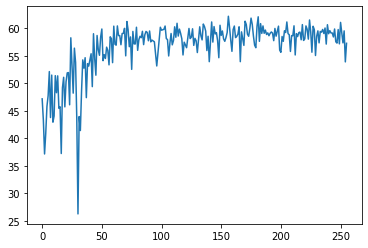

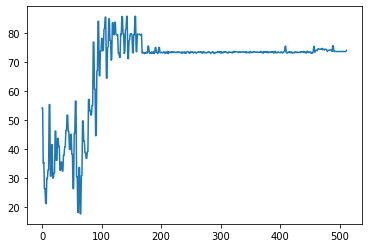

In [5]:
import matplotlib.pyplot as plt

plt.plot(val_accuracy_list)
plt.figure()
plt.plot(train_time_list)